In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from kaizoji_model.kaizoji_model import KaizojiModel

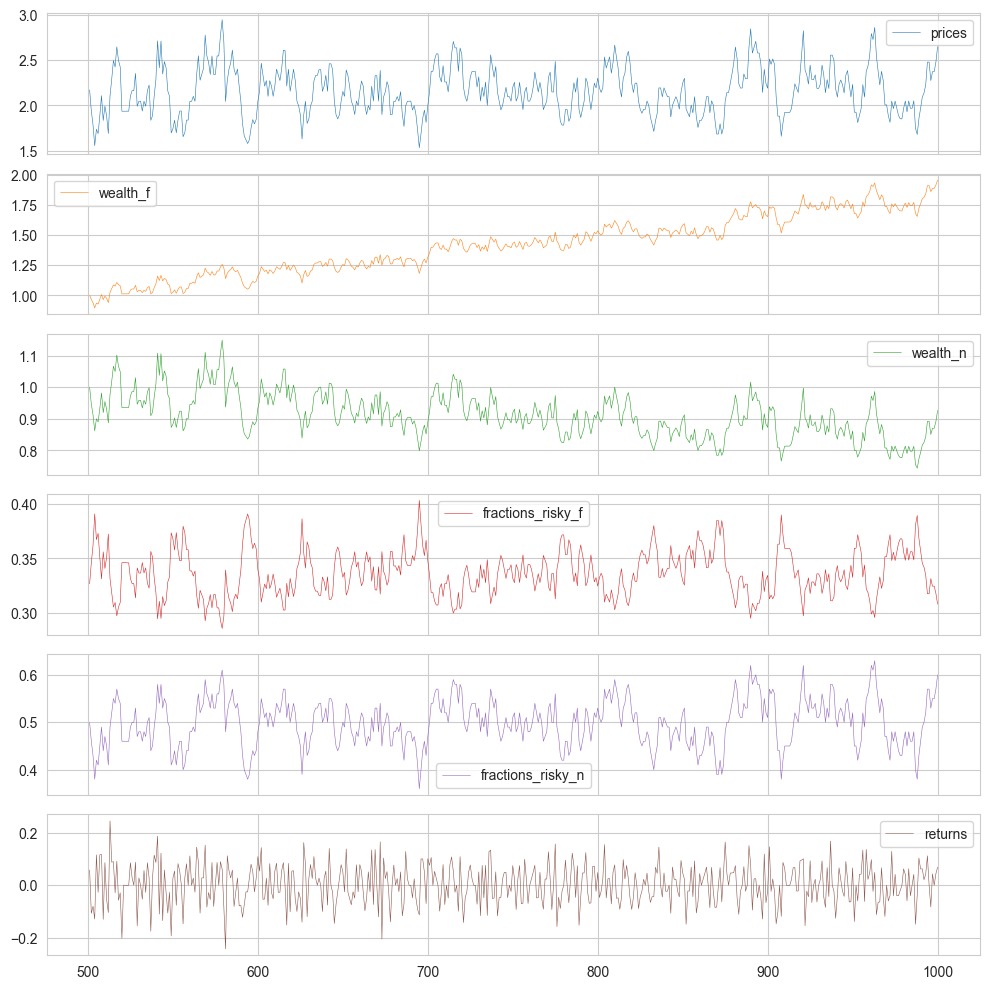

In [15]:
# simulate
new_model = KaizojiModel(W_N_ZERO=10000_000, W_F_ZERO=10000_000)
new_model.simulate(1000)
df = pd.DataFrame(new_model.get_variables())
last_periods = 500

# normalize wealth
df.wealth_f = df.wealth_f/df.wealth_f[len(df.wealth_f) - last_periods]
df.wealth_n = df.wealth_n/df.wealth_n[len(df.wealth_f) - last_periods]
df['returns'] = [0] + [df.prices[i]/df.prices[i-1] - 1 for i in range(1, len(df.wealth_f))]
df = df[['prices', 'wealth_f', 'wealth_n', 'fractions_risky_f', 'fractions_risky_n', 'returns']]


df.tail(last_periods).plot(subplots=True, figsize = [10,10], linewidth=0.4)
plt.tight_layout()
plt.show();

In [ ]:
df.head()

In [10]:
# the same parameter many times for Sharpe
sharpe = {'f':[], 'n':[]}
count = 0
for i in range(100):
    model = KaizojiModel(W_N_ZERO=10000_0000, W_F_ZERO=10000_000)
    model.simulate(1000)
    sharpe['f'].append(model.get_sharpe_f())
    sharpe['n'].append(model.get_sharpe_n())

    count +=1
    if count%10==0:
        print(count/10, '%')
plt.hist(sharpe['f']);

1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %


NameError: name 'plt' is not defined

In [ ]:
# many parameters sharpe
# the same parameter many times for Sharpe
from collections import defaultdict

sharpe = defaultdict(list)
temp_list = []
count = 0
for w_n in [1E7, 5E7, 1E8, 5E8, 1E9]:
    for i in range(100):
        model = KaizojiModel(W_N_ZERO=w_n, W_F_ZERO=1E8)
        model.simulate(1000)
        sharpe[(w_n/1E8, 'f')].append(model.get_sharpe_f())
        sharpe[(w_n/1E8, 'n')].append(model.get_sharpe_n())

        count +=1
        if count%10==0:
            print(count/5, '%')

['f', 'n']
f 0.7037565373738051
n -0.19799440467908275


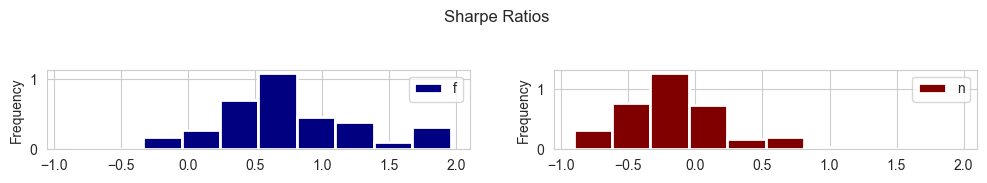

In [13]:
# plot many sharpe ratios
df_sharpe = pd.DataFrame(sharpe)
axes = df_sharpe.plot(kind='hist',rot=0, lw=2, colormap='jet',figsize=(12,6),
             title='Sharpe Ratios', subplots=True, layout=(5,2), density=True)

print(df_sharpe.columns.to_list())
for col in df_sharpe.columns.to_list():
    print(col, np.median(df_sharpe[col]))

plt.show();

In [ ]:
for elem in axes:
    print(elem[0])

In [ ]:
sns.displot(data=df_sharpe, kde=True)

In [6]:
# many parameters resilience
# the same parameter many times for Sharpe
from collections import defaultdict
from scipy.stats import kurtosis
from scipy.stats import skew
import numpy as np
import pandas as pd
from kaizoji_model.kaizoji_model import KaizojiModel

returns = {}
temp_list = []
count = 0
for w_n in [i * 1E7 for i in range(0, 21, 4)]:
    for gam in np.arange(0.2, 1.1, 0.2):
        model = KaizojiModel(W_N_ZERO=w_n, W_F_ZERO=1E8, SEED=4222, GAMMA=gam)
        model.simulate(2500)
        returns[(gam, w_n/1E8)] = model.returns[int(0.9*model.curr_day):]

metrics = defaultdict(list)
for key in returns:
    metrics[key].append(np.std(returns[key])) #std
    metrics[key].append(skew(returns[key])) #skew
    metrics[key].append(kurtosis(np.abs(returns[key]))) #extra kurtosis
    metrics[key].append(pd.Series(returns[key]).quantile(0.05)) # 95% var
    metrics[key].append(pd.Series(returns[key]).quantile(0.01)) # 99% var



In [7]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['std', 'skew', 'exc_kurt', '95% VaR', '99% VaR']

In [9]:
df_temp = pd.DataFrame()
for col in df_metrics:
    if col[0] == 0.2:
        df_temp[col[1]] = df_metrics[col]
df_temp

,0.0,0.4,0.8,1.2,1.6,2.0
std,0.000302,0.011883,0.015709,0.017529,0.018634,0.019771
skew,-0.091126,0.183781,-0.128346,0.043526,0.284771,-0.321569
exc_kurt,0.357022,0.833755,0.688985,0.061193,0.834592,1.936441
95% VaR,-0.000324,-0.018909,-0.024979,-0.025227,-0.026969,-0.037003
99% VaR,-0.000482,-0.024875,-0.035315,-0.039463,-0.036690,-0.048238


In [ ]:
# Distribution of absolute daily returns
from scipy.stats import norm, kurtosis
print(kurtosis(np.abs(df.returns)))
plt.hist(df.returns);

In [ ]:
# CHOOSE PARAMETERS
res = {}
err = set()
wealth = np.arange(1E6, 1E8, 1E6)
count = 0
for f in wealth:
    if count %10 == 0:
        print(count*100/len(wealth), '%')
    for n in wealth:
        try:
            model = KaizojiModel(W_F_ZERO=f, W_N_ZERO=n)
            model.simulate(1000)
            if model.prices[-1] > 0:
                res[(f,n)] = np.mean(model.prices)
            else:
                err.add((f, n))
        except (ValueError,ZeroDivisionError):
            err.add((f, n))
    count += 1

print(res)

In [ ]:
# in case model stopped at some point due to error and one wants to retrieve values
'''
faulty_vars = new_model.get_variables()

# find min length of parameters array
min_len = 1E100
for value in faulty_vars.values():
    min_len = min(min_len, len(value))

# trim each array to min level
for key in faulty_vars:
    while len(faulty_vars[key]) != min_len:
        faulty_vars[key].pop()

df = pd.DataFrame(faulty_vars)
df.head()
'''